In [1]:
### Installs/imports
#!pip install torch transformers datasets tabulate scikit-learn seaborn accelerate bitsandbytes
from initialize import *
from enhanced_hooking import get_activations, add_activations_and_generate, clear_hooks, get_activations_and_generate, zeroout_projections_and_generate
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from collections import defaultdict
from enum import Enum
class SteeringType(Enum):
    IN_PROMPT = "In prompt"
    CONTINUOUS = "Continuous"
class AggType(Enum):
    MEANDIFF = "MeanDiff"
    PCA = "PCA"

%load_ext autoreload
%autoreload 2

In [2]:
### Load the model

gc.collect()
torch.cuda.empty_cache()
base_model_path: str = "meta-llama/Meta-Llama-3.1-8B-Instruct"#"meta-llama/Llama-2-13b-chat-hf"
model_path=base_model_path
###model_path="cackerman/llama2_13b_chat_projection_tune_neg_in"

#device: str = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu" 
#model = load_model(model_path, base_model_path, device)

from transformers import BitsAndBytesConfig
bnb_config = BitsAndBytesConfig(load_in_8bit=True)
_ = torch.set_grad_enabled(False)
model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float16, token=HF_TOKEN, quantization_config=bnb_config, device_map="auto")
device = model.device
tokenizer = AutoTokenizer.from_pretrained(base_model_path, token=HF_TOKEN)
model.tokenizer = tokenizer
if model.tokenizer.pad_token is None:
    new_pad_token = model.tokenizer.eos_token
    num_added_tokens = model.tokenizer.add_special_tokens({'pad_token': new_pad_token})
    model.resize_token_embeddings(len(model.tokenizer))
    model.config.pad_token_id = model.tokenizer.pad_token_id
model_numlayers = model.config.num_hidden_layers

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
model.eval()  
sampling_kwargs={"use_cache": True, "pad_token_id": model.tokenizer.eos_token_id, "max_new_tokens": 200, "do_sample": False}

#input_text=LLAMA3_PROMPT_TEMPLATE.format(system_prompt="Answer concisely.",user_prompt="What's the difference between a fruit and a vegetable?")
input_text += output + "<|eot_id|><|start_header_id|>user<|end_header_id|>Oh, I see. That explains why there's often confusion about tomatoes. Are there any other common foods that are botanically classified differently from how we typically think of them?<|eot_id|><|start_header_id|>assistant<|end_header_id|>"
input_ids = model.tokenizer.encode(input_text, return_tensors="pt").to(model.device)
with torch.no_grad():
    output = model.tokenizer.decode(model.generate(input_ids[:,:-1],**sampling_kwargs)[0][len(input_ids[0])-1:],skip_special_tokens=True)
print(f"Input: {input_text}")
print(f"Output: {output}")

In [ ]:
#!pip install anthropic
import anthropic
import string

def random_string(length=10):
    return ''.join(random.choices(string.ascii_letters + string.digits, k=length))

def randomize_prompt(prompt, n_changes=4):
    # Convert the prompt to a list of characters for easy manipulation
    chars = list(prompt)
    
    # Find indices of letters (not spaces or punctuation)
    letter_indices = [i for i, char in enumerate(chars) if char.isalpha()]
    
    # Ensure we don't try to change more letters than exist
    n_changes = min(n_changes, len(letter_indices))
    
    # Randomly select indices to change
    indices_to_change = random.sample(letter_indices, n_changes)
    
    # Change selected letters
    for index in indices_to_change:
        # Get a random letter, ensuring it's different from the original
        new_letter = random.choice(string.ascii_letters)
        while new_letter.lower() == chars[index].lower():
            new_letter = random.choice(string.ascii_letters)
        
        chars[index] = new_letter
    
    # Convert back to a string
    return ''.join(chars)
    
api_key = os.environ.get("ANTHROPIC_API_KEY_SPAR")
client = anthropic.Anthropic(api_key=api_key)
model.eval()  
sampling_kwargs={"use_cache": True, "pad_token_id": model.tokenizer.eos_token_id, "max_new_tokens": 200, "do_sample": True}

llama_template = "<|start_header_id|>{role}<|end_header_id|>{prompt}<|eot_id|>"

n_convos = 50
n_rounds = 3
###conversations = []
last_written_index = len(conversations)
llama_system_prompt = "Answer concisely."
#seed_prompt = "I want to try something a little different. Instead of me leading the conversation and asking you questions, I want you to play my role: Pretend that you are a human talking with an AI assistant. Start a conversation by asking a (relatively simple) question about {topic}, and then continue it with follow-up remarks and questions based on the answer. Your questions should be simple enough that the AI can answer them with 1-3 sentences. Preface each of your questions with \"Human: \"."
seed_prompt = "I want to try something a little different. Instead of me leading the conversation and asking you questions, I want you to play my role: Pretend that you are a human talking with an AI assistant. Start a conversation by asking a (relatively simple) question, and then continue it with follow-up remarks and questions based on the answer. Your questions should be simple enough that the AI assistant can answer them with 1-3 sentences. Preface your question with \"Human: \""
###qs=[]

for c in range(len(conversations),n_convos):
    print("conversation counter=",c)
    conversation = llama_template.format(role="system", prompt=llama_system_prompt)
    suffix = " Preface your question with \"Human: \"" if c == 0 else f" Pick a question that's NOT in this list: {', '.join(qs)}. Preface your question with \"Human: \""
    claude_messages = [
        {"role": "user", "content": seed_prompt+suffix}#seed_prompt.format(topic=topics[c])}
    ]
    for r in range(n_rounds):
        message = client.messages.create(
            model="claude-3-5-sonnet-20240620",
            #temperature = 0,#round(random.uniform(0, 1), 1),
            system = "Do NOT include \"Sure\", \"Okay\", or any other acknowledgement in your response.",#f"Random seed: {random_string()}",
            max_tokens=200,
            messages=claude_messages
        )
        resp = message.content[0].text.strip()
        if "Human: " in resp:
            resp_cln = resp.split("Human: ")[1].strip()
        elif "\n" in resp:
            resp_cln = resp.split("\n",1)[1].strip()
        else: resp_cln=resp
        if(r==0): 
            print("resp=",resp)
            qs.append(resp_cln)
        claude_messages.append({"role": "assistant", "content": resp})

        conversation += llama_template.format(role="user", prompt=resp_cln) + "<|start_header_id|>assistant<|end_header_id|>"

        input_ids = model.tokenizer.encode(conversation, return_tensors="pt").to(model.device)
        output=""
        with torch.no_grad():
            while output == "":
                output = model.tokenizer.decode(model.generate(input_ids,**sampling_kwargs)[0][len(input_ids[0]):],skip_special_tokens=True).strip()

        claude_messages.append({"role": "user", "content": output})

        conversation += output + "<|eot_id|>"
    conversations.append(conversation)
    if (c + 1) % 10 == 0:
        new_conversations = conversations[last_written_index:]
        with open('conversations.json', 'a') as f:
            json.dump(new_conversations, f)
            f.write('\n')
        last_written_index = len(conversations)  

if last_written_index < len(conversations):
    new_conversations = conversations[last_written_index:]
    with open('conversations.json', 'a') as f:
        json.dump(new_conversations, f)
        f.write('\n')

In [ ]:
sampling_kwargs={"use_cache": True, "max_new_tokens": 4000, "do_sample": True}
input_ids = model.tokenizer.encode("<|start_header_id|>system<|end_header_id|>Answer concisely.<|eot_id|><|start_header_id|>user<|end_header_id|>Hi there! I'm curious about the Great Wall of China. When was it built?<|eot_id|><|start_header_id|>assistant<|end_header_id|>The Great Wall of China was built in multiple stages over several centuries, with the earliest versions dating back to the 7th century BC. The most famous and well-preserved versions were built during the Ming Dynasty (1368-1644 AD).<|eot_id|><|start_header_id|>user<|end_header_id|>That's fascinating! I had no idea it was built over such a long period. What was the main purpose of building the Great Wall?<|eot_id|><|start_header_id|>assistant<|end_header_id|>", return_tensors="pt").to(model.device)
with torch.no_grad():
    genids=model.generate(input_ids,**sampling_kwargs)
    output=model.tokenizer.decode(genids[0][len(input_ids[0]):],skip_special_tokens=True).strip()


In [ ]:
qs=qs[:39]

In [149]:
claude_messages

[{'role': 'user',
  'content': 'I want to try something a little different. Instead of me leading the conversation and asking you questions, I want you to play my role: Pretend that you are a human talking with an AI assistant. Start a conversation by asking a (relatively simple) question, and then continue it with follow-up remarks and questions based on the answer. Your questions should be simple enough that the AI assistant can answer them with 1-3 sentences. Preface your question with "Human: " Pick a question that\'s NOT in this list: What\'s the capital city of France?, What\'s the largest planet in our solar system?, What\'s the main ingredient in guacamole?, What\'s the average lifespan of a house cat?, What\'s the boiling point of water in Fahrenheit?, What\'s the primary function of the human appendix?, What\'s the most popular sport in Brazil?, What\'s the most common element in Earth\'s atmosphere?, What\'s the typical gestation period for an elephant?, What\'s the deepest 

In [ ]:
topics = []
messages=[{"role": "user", "content": "Choose a conversational topic."}]
for i in range(50):
    message = client.messages.create(
            model="claude-3-5-sonnet-20240620",
            temperature = round(random.uniform(0, 1), 1),
            system = "The topic should be a simple, well-known one. Respond only with the topic and no other words",
            max_tokens=20,
            messages=messages
        )
    resp=message.content[0].text.strip()
    messages.append({"role": "assistant", "content": resp})
    topics.append(resp)
    messages.append({"role": "user", "content": "Choose a conversational topic that you haven't already suggested."})

In [23]:

print([conversations[0]])

["<|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\nAnswer concisely.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nWhat's the capital city of France?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nParis.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nThat's right! Have you ever been to Paris yourself?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nI'm just an AI, I don't have personal experiences or physically visit places. I can provide information about Paris and other locations based on my training data, but I don't have firsthand experiences.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nOh, I see. Well, can you tell me one famous landmark in Paris then?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nThe Eiffel Tower!<|eot_id|>"]


In [14]:
model.tokenizer.encode('<|start_header_id|>assistant<|end_header_id|>')

[128000, 128006, 78191, 128007]

In [22]:
## contrastive prompts user and assistant tokens

with open("conversations.json") as f:
    conversations = json.load(f)

conversations = [c.replace("<|end_header_id|>","<|end_header_id|>\n\n").replace("\n\nAnswer concisely.","\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\nAnswer concisely.") for c in conversations]

layers = range(model_numlayers)
model.tokenizer.padding_side = "right"
clear_hooks(model)

accumulated_activations_pos = defaultdict(lambda: defaultdict(lambda: torch.empty(0)))
accumulated_activations_neg = defaultdict(lambda: defaultdict(lambda: torch.empty(0)))
accumulated_activations_pos_summed = defaultdict(lambda: defaultdict(lambda: torch.empty(0)))
accumulated_activations_neg_summed = defaultdict(lambda: defaultdict(lambda: torch.empty(0)))

batch_size = 2
get_at="end"

# Token IDs for user and assistant markers
user_marker_ids = [128006, 882, 128007]  # <|start_header_id|>user<|end_header_id|>
assistant_marker_ids = [128006, 78191, 128007]  # <|start_header_id|>assistant<|end_header_id|>

def find_token_positions(sequence, marker_ids):
    """Find all the positions where the marker_ids appear in the tokenized sequence."""
    positions = []
    for i in range(len(sequence) - len(marker_ids) + 1):
        if sequence[i:i+len(marker_ids)] == marker_ids:
            positions.extend(range(i, i + len(marker_ids)))  # Capture the whole sequence
#            positions.append(i)# capture the token before the role tag + 1)  # Capture the role tag
    return positions

for bi in tqdm(range(0, len(conversations), batch_size)):
    batch = conversations[bi:bi+batch_size]
    # Tokenize inputs and extract input IDs and attention masks
    encoded = model.tokenizer(batch, return_tensors="pt", padding=True)
    batch_tokens = encoded['input_ids']
    
    layers_positions = {}
    
    # Find the token positions corresponding to "assistant" markers in each sequence
    for batch_idx, sequence in enumerate(batch_tokens.tolist()):
        assistant_positions = find_token_positions(sequence, assistant_marker_ids)
                
        # Store positions for each layer
        for layer in layers:
            if layer not in layers_positions:
                layers_positions[layer] = []
            layers_positions[layer].append(assistant_positions)

    activations = get_activations(model, batch_tokens, layers_positions, get_at=get_at) #returns a dictionary where keys are layers and values are dicts where keys are positions and values are batchsize d-embed tensors
    for layer, positions in activations.items():
        batch_size = next(iter(positions.values())).shape[0]  # Get batch size from any position tensor
        d_embed = next(iter(positions.values())).shape[-1]  # Get d_embed size from any tensor
        layer_sum = torch.zeros(batch_size, d_embed)  # Initialize a tensor to sum activations over positions

        # Sum activations over positions for the "assistant" tokens in this layer
        idlen = len(assistant_marker_ids)
        layersums = torch.zeros(idlen, batch_size, d_embed)  # Initialize a tensor to sum activations over positions
        for pi,(pos, tensor) in enumerate(positions.items()):
            layer_sum += tensor/len(positions.items())  # Sum activations across positions for this layer
            layersums[pi%idlen,:,:] += tensor/(len(positions.items())/idlen)
        accumulated_activations_pos_summed[layer][0] = torch.cat([accumulated_activations_pos_summed[layer][0], layer_sum], dim=0)

        for pos,toksum in enumerate(layersums):
            accumulated_activations_pos[layer][pos] = torch.cat([accumulated_activations_pos[layer][pos], toksum], dim=0)

    layers_positions = {}

    # Find the token positions corresponding to "user" markers in each sequence
    for batch_idx, sequence in enumerate(batch_tokens.tolist()):
        user_positions = find_token_positions(sequence, user_marker_ids)
        
        for layer in layers:
            if layer not in layers_positions:
                layers_positions[layer] = []
            layers_positions[layer].append(user_positions)
    activations = get_activations(model, batch_tokens, layers_positions, get_at=get_at)
    for layer, positions in activations.items():
        batch_size = next(iter(positions.values())).shape[0]  # Get batch size from any position tensor
        d_embed = next(iter(positions.values())).shape[-1]  # Get d_embed size from any tensor
        layer_sum = torch.zeros(batch_size, d_embed)  # Initialize a tensor to sum activations over positions
        
        # Sum activations over positions for the "user" tokens in this layer
        idlen = len(user_marker_ids)
        layersums = torch.zeros(idlen, batch_size, d_embed)  # Initialize a tensor to sum activations over positions
        for pi,(pos, tensor) in enumerate(positions.items()):
            layer_sum += tensor/len(positions.items())  # Sum activations across positions for this layer
            layersums[pi%idlen,:,:] += tensor/(len(positions.items())/idlen)
        accumulated_activations_neg_summed[layer][0] = torch.cat([accumulated_activations_neg_summed[layer][0], layer_sum], dim=0)

        for pos,toksum in enumerate(layersums):
            accumulated_activations_neg[layer][pos] = torch.cat([accumulated_activations_neg[layer][pos], toksum], dim=0)
        
    
meandiffs = {}
for layer, positions in accumulated_activations_pos_summed.items():
    meandiffs[layer] = []
    for pos in range(len(positions)):
        meandiffs[layer].append(torch.mean((accumulated_activations_pos_summed[layer][pos]-accumulated_activations_neg_summed[layer][pos]), dim=0))
normedmeandiffs = {}
for layer, positions in meandiffs.items():
    normedmeandiffs[layer] = []  
    for pos in range(len(positions)):
        normedmeandiffs[layer].append(meandiffs[layer][pos] / torch.norm(meandiffs[layer][pos], p=2, dim=0, keepdim=True))

100%|██████████| 25/25 [00:13<00:00,  1.84it/s]


In [25]:
import pickle
ofname = 'steering_vectors_roles_summed_newlines_nonorm_3.1.pkl'
with open(ofname, 'wb') as f:
    pickle.dump(meandiffs, f)

In [5]:
import pickle
with open('/home/spar_self_recognition/steering_vectors_nina.pkl', 'rb') as f:
    steering_vectors_nina=pickle.load(f)

In [16]:
meandiffs[16][0][:10],meandiffs[20][0][-10:]

(tensor([-0.0003, -0.0836,  0.0058,  0.0871, -0.0139,  0.0348,  0.0046,  0.0549,
          0.1094,  0.1277]),
 tensor([ 0.0428,  0.0217, -0.1018,  0.0571,  0.0568, -0.1117, -0.0188, -0.0327,
         -0.0021, -0.0905]))

In [9]:
import copy
meandiffs2 = copy.deepcopy(meandiffs)

In [12]:
meandiffs2[16][0][:10],meandiffs2[20][0][-10:]

(tensor([-0.0015, -0.0846,  0.0051,  0.0895, -0.0130,  0.0326,  0.0053,  0.0539,
          0.1087,  0.1298]),
 tensor([ 0.0443,  0.0233, -0.1035,  0.0585,  0.0549, -0.1160, -0.0173, -0.0304,
          0.0019, -0.0892]))

In [24]:
for layer in range(len(meandiffs)):
    for pos in range(len(meandiffs[layer])):
        steering_vector = meandiffs[layer][pos]
        steering_vector_honesty = steering_vectors_nina[layer]
        print(f"Layer {layer}, pos {pos} cosine sim is {(steering_vector @ steering_vector_honesty) / (torch.norm(steering_vector_honesty) * torch.norm(steering_vector))}")

Layer 0, pos 0 cosine sim is 0.9953730702400208
Layer 1, pos 0 cosine sim is 0.9953643083572388
Layer 2, pos 0 cosine sim is 0.9959202408790588
Layer 3, pos 0 cosine sim is 0.9943037629127502
Layer 4, pos 0 cosine sim is 0.9943366050720215
Layer 5, pos 0 cosine sim is 0.9948425889015198
Layer 6, pos 0 cosine sim is 0.9958256483078003
Layer 7, pos 0 cosine sim is 0.9964765906333923
Layer 8, pos 0 cosine sim is 0.9955930709838867
Layer 9, pos 0 cosine sim is 0.9955975413322449
Layer 10, pos 0 cosine sim is 0.9957265257835388
Layer 11, pos 0 cosine sim is 0.9957350492477417
Layer 12, pos 0 cosine sim is 0.9956815838813782
Layer 13, pos 0 cosine sim is 0.9951934814453125
Layer 14, pos 0 cosine sim is 0.9951204061508179
Layer 15, pos 0 cosine sim is 0.9943308234214783
Layer 16, pos 0 cosine sim is 0.9934642314910889
Layer 17, pos 0 cosine sim is 0.992615282535553
Layer 18, pos 0 cosine sim is 0.9917009472846985
Layer 19, pos 0 cosine sim is 0.9909688234329224
Layer 20, pos 0 cosine sim is 0

In [11]:
### Compute direction vectors from activations to contrastive prompts

agg_type = AggType.MEANDIFF#PCA#
normvec = False
use_raw = False

def get_sign(activations_pos, activations_neg, direction): 
    #decide whether each direction vector is oriented such that "honesty" is high or low, based on a majority vote count of exemplar projections (ie, does the pos example in a pair tend to project higher or lower than the neg example)
    projections_pos = (activations_pos @ direction) / torch.norm(direction)
    projections_neg = (activations_neg @ direction) / torch.norm(direction)

    positive_smaller_mean = np.mean(
        [projections_pos[i] < projections_neg[i] for i in range(len(projections_pos))]
    )
    positive_larger_mean = np.mean(
        [projections_pos[i] > projections_neg[i] for i in range(len(projections_pos))]
    )
    return -1 if positive_smaller_mean > positive_larger_mean else 1

if agg_type == AggType.MEANDIFF: #will also work for simple word/prefix substraction case as in the original steering activation post
    steering_vectors = {}
    
    for layer, positions in accumulated_activations_pos.items():
        steering_vectors[layer] = []
        for pos in range(len(positions)):
            steering_vectors[layer].append((accumulated_activations_pos[layer][pos]-accumulated_activations_neg[layer][pos]).mean(dim=0))
            if normvec:
                steering_vectors[layer][pos] /= torch.norm(steering_vectors[layer][pos], p=2, dim=0, keepdim=True)    
    """
    for layer, positions in accumulated_activations_diffs.items():
        steering_vectors[layer] = []
        for pos in range(len(positions)):
            steering_vectors[layer].append(torch.mean(accumulated_activations_diffs[layer][pos], dim=0))
            if normvec:
                steering_vectors[layer][pos] /= torch.norm(steering_vectors[layer][pos], p=2, dim=0, keepdim=True)  
    """
elif agg_type == AggType.PCA: # get directions for each layer and position using PCA  
    # takes second PC currently, but can take others or weight and combine  
    if use_raw:
        dummyvec_pc2raw_steering_vectors = {} #dictionary where keys are layers and values are lists of n_pos direction tensors
        for layer, positions in accumulated_activations_pos.items():#dictionary where keys are layers and values are dicts where keys are positions and values are len(dataset) d-embed tensors
            embeds = []
            for pos in range(len(positions)):
                activations_pos = accumulated_activations_pos[layer][pos]
                activations_neg = accumulated_activations_neg[layer][pos]

                activations = torch.cat([activations_pos, activations_neg], dim=0)
                pca_model = PCA(n_components=2)
                projected_activations = pca_model.fit_transform(activations)#[:,1]
                coef1, coef2 = 0,1#pca_model.explained_variance_[0],pca_model.explained_variance_[1]
                embeds.append(torch.from_numpy(pca_model.components_[0].astype(np.float32))*coef1/(coef1+coef2)*get_sign(accumulated_activations_pos[layer][pos],accumulated_activations_neg[layer][pos],torch.from_numpy(pca_model.components_[0].astype(np.float32))))
                embeds[-1]+=torch.from_numpy(pca_model.components_[1].astype(np.float32))*coef2/(coef1+coef2)*get_sign(accumulated_activations_pos[layer][pos],accumulated_activations_neg[layer][pos],torch.from_numpy(pca_model.components_[1].astype(np.float32)))
            dummyvec_pc2raw_steering_vectors[layer] = torch.stack(embeds)
    else:
        selfrecvec_pc1diff_steering_vectors = {} #dictionary where keys are layers and values are lists of n_pos direction tensors
        for layer, positions in selfrecvec_accumulated_activations_diffs.items():#dictionary where keys are layers and values are dicts where keys are positions and values are len(dataset) d-embed tensors
            embeds = []
            for pos in range(len(positions)):
                train = positions[pos] - positions[pos].mean(axis=0, keepdims=True)
                pca_model = PCA(n_components=2, whiten=False).fit(train)
                coef1, coef2 = 1,0#pca_model.explained_variance_[0],pca_model.explained_variance_[1]
                embeds.append(torch.from_numpy(pca_model.components_[0].astype(np.float32))*coef1/(coef1+coef2)*get_sign(selfrecvec_accumulated_activations_pos[layer][pos],selfrecvec_accumulated_activations_neg[layer][pos],torch.from_numpy(pca_model.components_[0].astype(np.float32))))
                embeds[-1]+=torch.from_numpy(pca_model.components_[1].astype(np.float32))*coef2/(coef1+coef2)*get_sign(selfrecvec_accumulated_activations_pos[layer][pos],selfrecvec_accumulated_activations_neg[layer][pos],torch.from_numpy(pca_model.components_[1].astype(np.float32)))
            selfrecvec_pc1diff_steering_vectors[layer] = torch.stack(embeds)            
else: print("Unknown AGG_TYPE")


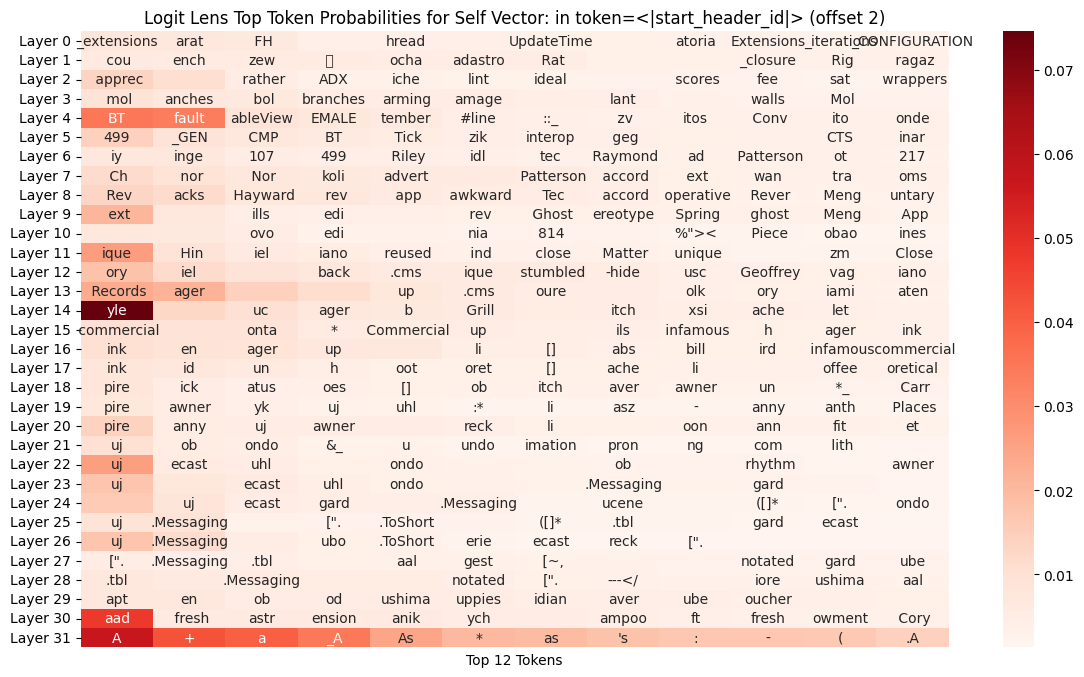

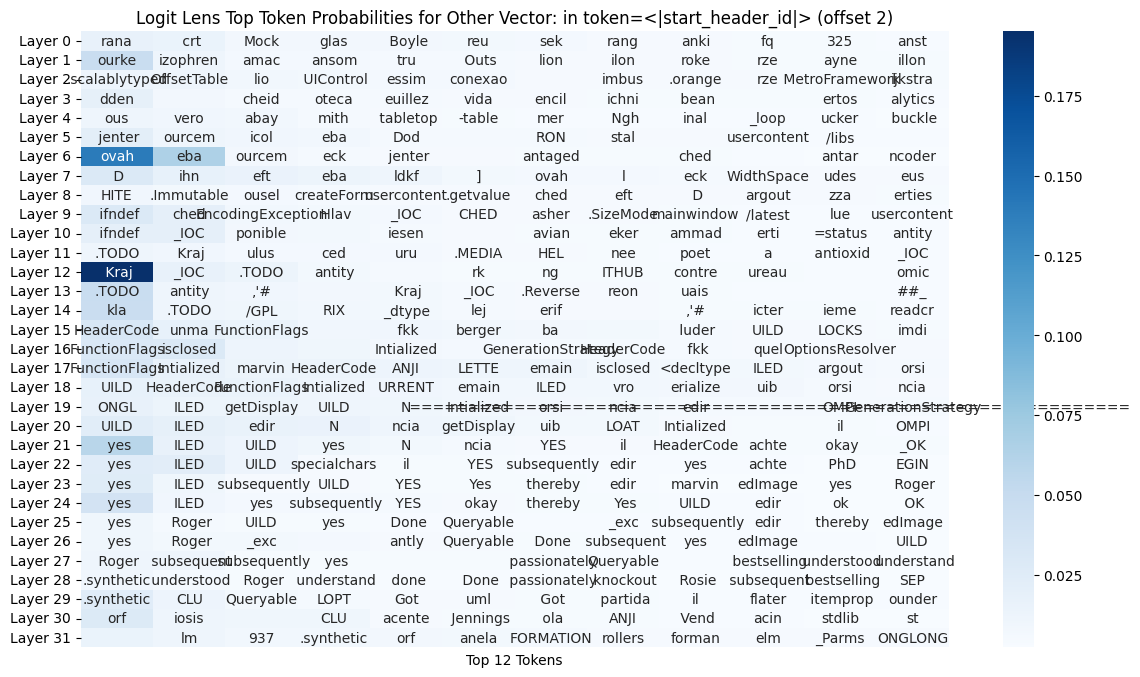

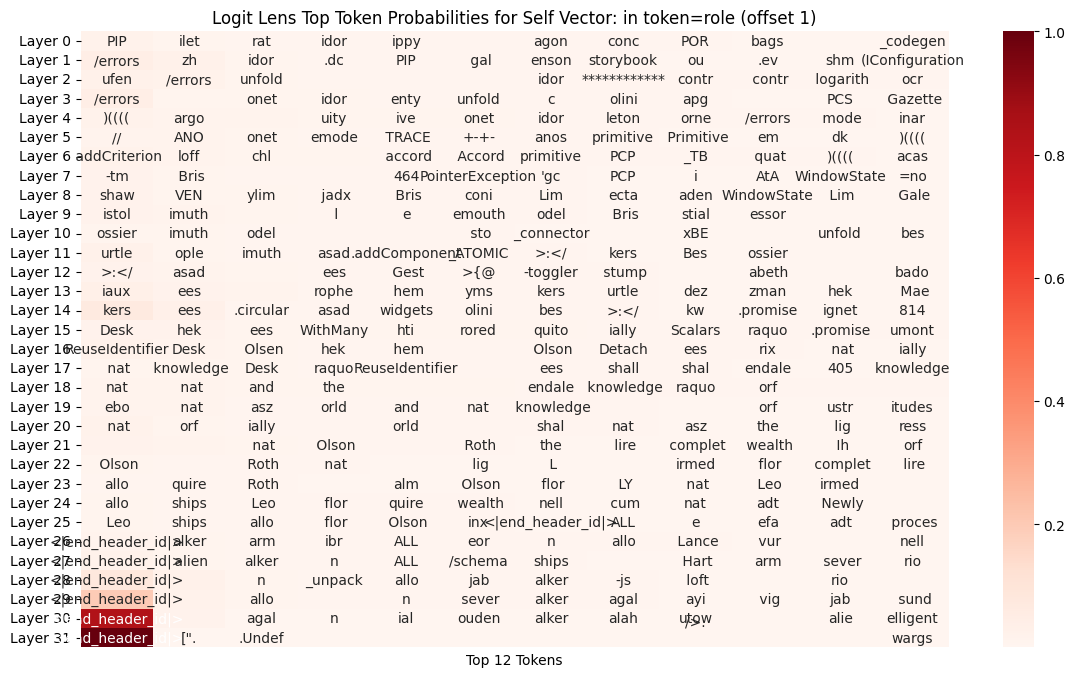

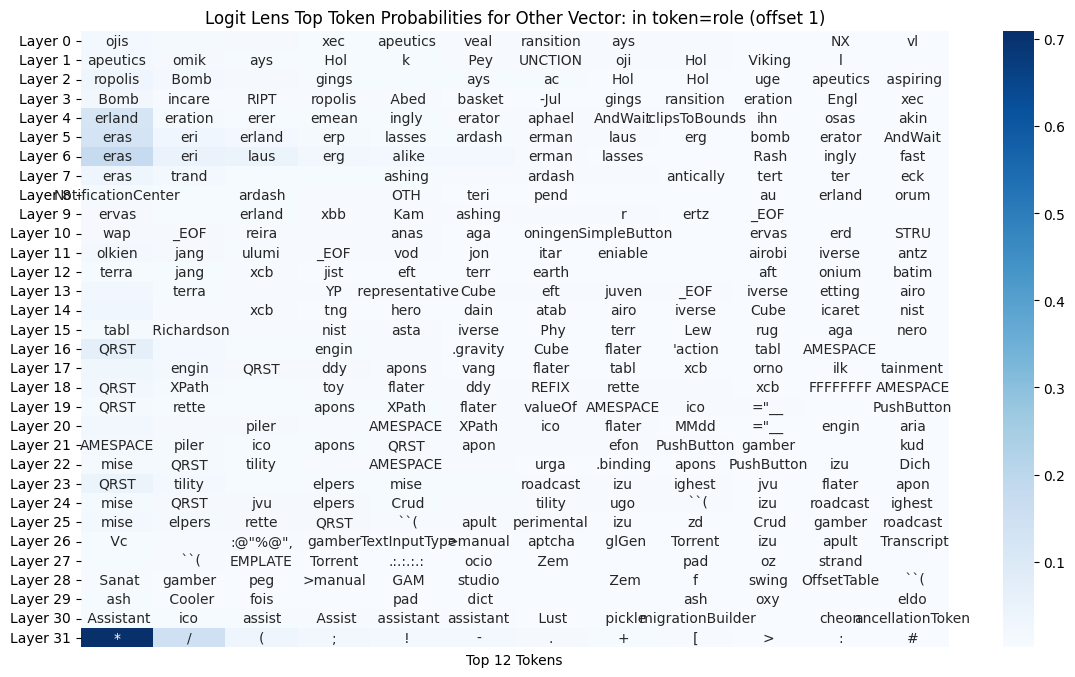

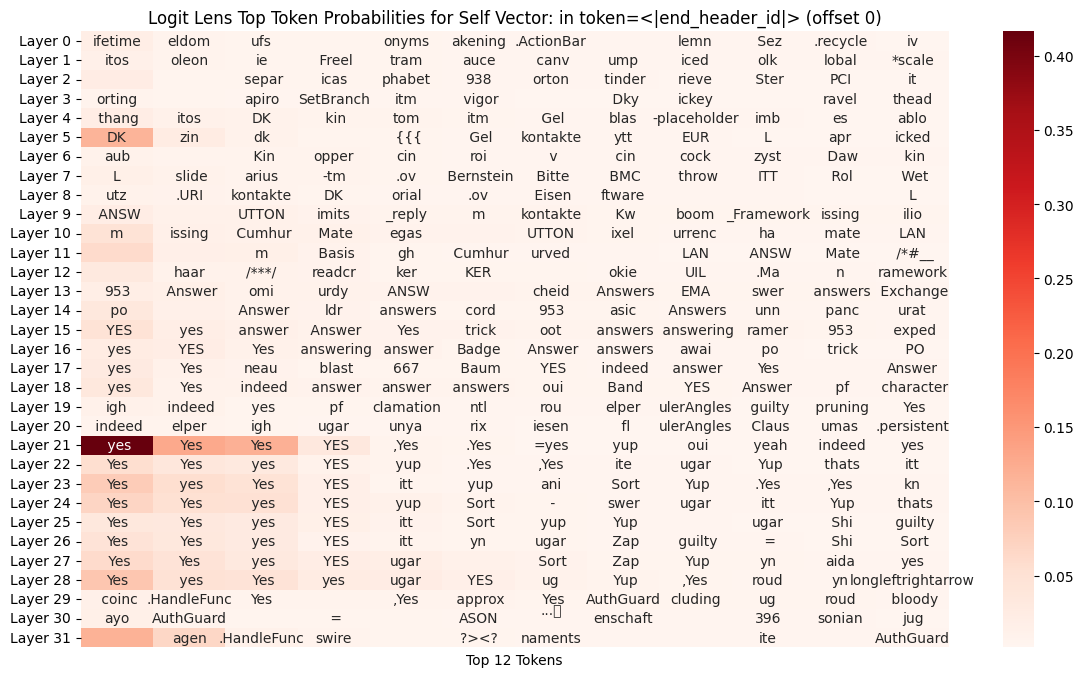

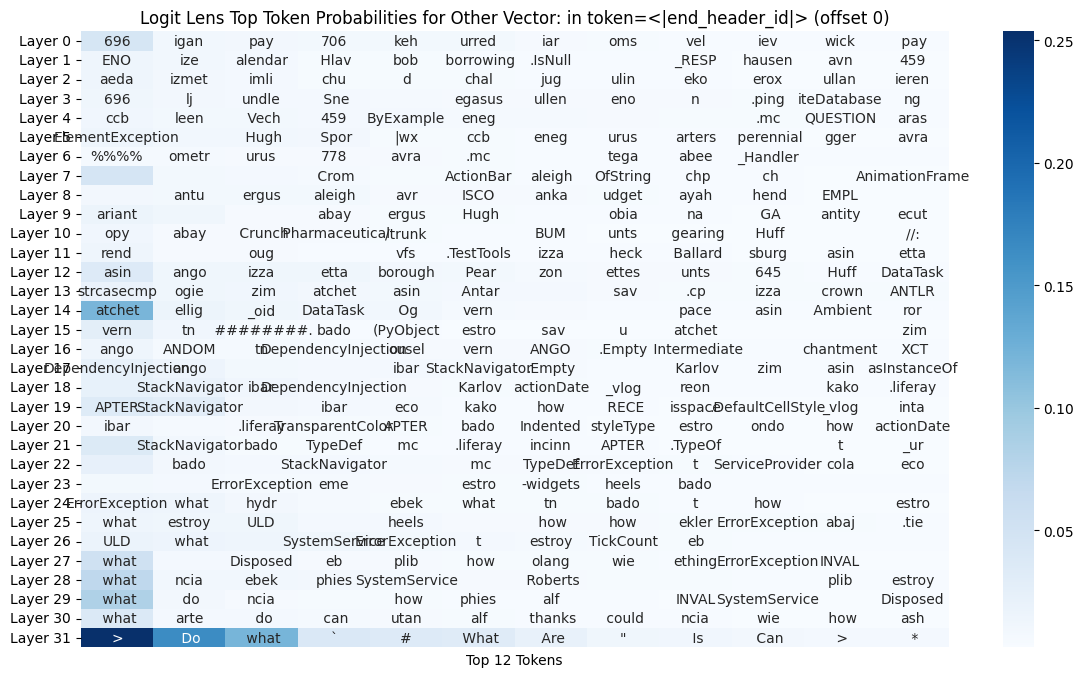

In [81]:
### Logit lens visualization of steering vector

import matplotlib.patches as patches
import warnings
warnings.filterwarnings("ignore", category=UserWarning)#, module='matplotlib')
#warnings.filterwarnings("ignore", message="Glyph*missing from current font.*")

def map_logit_lens(position, mult=1, topk=12, suffix=""):
    colorscale = "Reds" if mult>=0 else "Blues"
    
    token_data = []
    probs_data = []
    
    for layer in range(model_numlayers):
    
        #activations_pos = accumulated_activations_pos[layer][position]#[1::2]
        #activations_neg = accumulated_activations_neg[layer][position]#[1::2]
        #activations_diff = (activations_pos-activations_neg).mean(dim=0)
        #activations_diff /= torch.norm(activations_diff, p=2, dim=0, keepdim=True)
        #vec=(mult*activations_diff).to(device)
        
        #vec = steering_vectors[layer][position].clone()
        #vec[abs(vec) < 0.2] = 0
        #vec=(mult*vec).to(device)

 ###       vec=(mult * decoded_features[position]).to(device)
        vec=(mult*steering_vectors[layer][position].to(dtype=torch.float16)).to(device)
###        vec=(mult * meandiffs[layer][10]).to(device)
    #    vec=(mult * steering_vectors_combined[layer]).to(device)
    #    vec=(mult*normedmeandiffs[layer][0]).to(device)
        unembedded = model.lm_head(model.model.norm(vec.to(model.dtype)))
        softmaxed = torch.nn.functional.softmax(unembedded, dim=-1)
        values, indices = torch.topk(softmaxed, top_k)
        probs_percent = [v for v in values.tolist()]
        tokens = model.tokenizer.batch_decode(indices.unsqueeze(-1))
        token_data.append(tokens)
        probs_data.append(probs_percent) 
    
    probs_array = np.array(probs_data)
    token_labels = np.array(token_data)
    cleaned_token_labels = np.vectorize(lambda s: re.sub(r'[^\x00-\x7F]+', '', str(s)))(token_labels)
    # Replace any remaining problematic characters that might trigger MathText parsing
    cleaned_token_labels = np.vectorize(lambda s: re.sub(r'[\$\^\\]', '', s))(cleaned_token_labels)
    
    plt.rcParams['font.family'] = 'DejaVu Sans' 
    plt.figure(figsize=(14, 8))
    ax = sns.heatmap(probs_array, annot=cleaned_token_labels, fmt='', cmap=colorscale, xticklabels=False, yticklabels=[f"Layer {l}" for l in range(model_numlayers)])
    lbl="Self" if mult>0 else "Other"
    ax.set_title(f"Logit Lens Top Token Probabilities for {lbl} Vector{suffix}")
    ax.set_xlabel(f"Top {top_k} Tokens")
    
    # Adding a highlight for specific layers
    #for layerlist in [[17,18]]:
    #    rect = patches.Rectangle((0, layerlist[0]), top_k, len(layerlist), linewidth=2, edgecolor='red', facecolor='none')
    #    ax.add_patch(rect)
    
    plt.show()

position=10#priortoks-1
top_k = 12 
mult=-1
toks = ["<|start_header_id|>","role","<|end_header_id|>"]#model.tokenizer.tokenize(learn_directions_dataset[0][0])
###toks = model.tokenizer.tokenize(transform_task3(learn_directions_dataset[0][0],1))
token_offsets = [2,1,0]#[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]#[27,26,25,24,23,22,21,20,19,18,10,9,8,7,6,5,4,3,2,1,0]#
for i, offset in enumerate(token_offsets):
    #if i<12:continue
    for mult in [1,-1]:
        map_logit_lens(i, mult, top_k, suffix = f": in token={toks[-(offset+1)]} (offset {offset})")
